In [12]:
!pip install scikit-learn
!pip install pandas


In [13]:

from sklearn.preprocessing import LabelEncoder
import pandas as pd #import pandas library for reading CSV

# Load dataset
training_data = pd.read_csv('./Datasets/wildfires_training.csv')
test_data = pd.read_csv('./Datasets/wildfires_test.csv')
# Check to see if csv is loaded correctly
print(training_data.head())
print(test_data.head()) 

# Check to make sure test and training data have the same feature set.
training_first_row = training_data.iloc[0]  # Get the first row of the training dataset
test_first_row = test_data.iloc[0]          # Get the first row of the test dataset

# Assert that the first rows are equal
assert list(training_data.drop('fire', axis=1).columns) == list(test_data.drop('fire', axis=1).columns)


  fire  year  temp  humidity  rainfall  drought_code  buildup_index  day  \
0   no  2015    28        59       0.0          8.06           3.47    1   
1   no  2010    30        61       1.3          8.17           4.03    2   
2   no  2009    26        83      13.1          8.08           3.59    3   
3   no  2017    25        87       2.5          7.18           2.42    4   
4   no  2014    28        77       0.0         14.98           4.63    5   

   month  wind_speed  
0      6          19  
1      6          13  
2      6          22  
3      6          15  
4      6          18  
  fire  year  temp  humidity  rainfall  drought_code  buildup_index  day  \
0   no  2015    33        68       4.5          9.12           5.09   19   
1  yes  2009    28        56       0.0         38.17          21.21   12   
2   no  2017    30        64       0.6         15.38           6.24   24   
3   no  2007    23        74       8.3          7.36           2.27   14   
4   no  2017    31       

In [14]:
X_training = training_data.drop('fire', axis=1)  # Features (everything except "fire")
y_training = training_data['fire']   
print(X_training.head())  
print(y_training.head())           # Target variable (What I want to predict "fire" column)

   year  temp  humidity  rainfall  drought_code  buildup_index  day  month  \
0  2015    28        59       0.0          8.06           3.47    1      6   
1  2010    30        61       1.3          8.17           4.03    2      6   
2  2009    26        83      13.1          8.08           3.59    3      6   
3  2017    25        87       2.5          7.18           2.42    4      6   
4  2014    28        77       0.0         14.98           4.63    5      6   

   wind_speed  
0          19  
1          13  
2          22  
3          15  
4          18  
0    no
1    no
2    no
3    no
4    no
Name: fire, dtype: object


In [15]:

X_test = test_data.drop('fire', axis=1)  # Featuåres (everything except "fire")
y_test = test_data['fire']               # Target variable (What I want to predict "fire" column)
print(X_test.head())
print(y_test.head())  

   year  temp  humidity  rainfall  drought_code  buildup_index  day  month  \
0  2015    33        68       4.5          9.12           5.09   19      6   
1  2009    28        56       0.0         38.17          21.21   12      6   
2  2017    30        64       0.6         15.38           6.24   24      9   
3  2007    23        74       8.3          7.36           2.27   14      9   
4  2017    31        72       0.3         30.47           5.63    7      9   

   wind_speed  
0          16  
1          18  
2          19  
3          28  
4          17  
0     no
1    yes
2     no
3     no
4     no
Name: fire, dtype: object


In [16]:
# Entropy of the indepednent variable 
from scipy.stats import entropy
print(y_training.value_counts(normalize=True))  # Training data
training_entropy = entropy(y_training.value_counts(normalize=True), base=2)
print(f"Entropy of training data: {training_entropy}")

fire
yes    0.512987
no     0.487013
Name: proportion, dtype: float64
Entropy of training data: 0.9995132881417702


In [61]:
# Model fitting and accuracy evaluation default hyper parameters
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report

#Model with default settings
hbgc_model = HistGradientBoostingClassifier()
hbgc_model.fit(X_training, y_training)

#Compute accuracy on the training predictions
hbgc_model.predict(X_training)
accuracy = hbgc_model.score(X_training, y_training)

print("Accuracy on training dataset provided:", accuracy)
print(classification_report(y_training, hbgc_model.predict(X_training)))

Accuracy on training dataset provided: 1.0
              precision    recall  f1-score   support

          no       1.00      1.00      1.00        75
         yes       1.00      1.00      1.00        79

    accuracy                           1.00       154
   macro avg       1.00      1.00      1.00       154
weighted avg       1.00      1.00      1.00       154



In [56]:
#Compute accuracy on the training predictions without fine tuning
hbgc_model.predict(X_test)
accuracy = hbgc_model.score(X_test, y_test)

print("Accuracy on test dataset provided:", accuracy)
print(classification_report(y_test, hbgc_model.predict(X_test)))

Accuracy on test dataset provided: 0.84
              precision    recall  f1-score   support

          no       0.77      0.91      0.83        22
         yes       0.92      0.79      0.85        28

    accuracy                           0.84        50
   macro avg       0.84      0.85      0.84        50
weighted avg       0.85      0.84      0.84        50



# Model Hyperparameter Fine Tuning

In [49]:
from sklearn.ensemble import HistGradientBoostingClassifier

def find_best_hyperparameters(X_training, y_training, X_test, y_test, 
                               learning_rate_range=[0.01, 0.1, 0.2, 0.5, 1.0], 
                               min_samples_range=range(1, 51)):
    best_params = {"learning_rate": None, "min_samples_leaf": None}
    best_accuracy = 0.0

    for learning_rate in learning_rate_range:
        for min_samples_leaf in min_samples_range:
            # Create and train the model
            hgbc_model = HistGradientBoostingClassifier(learning_rate=learning_rate, min_samples_leaf=min_samples_leaf)
            hgbc_model.fit(X_training, y_training)
            
            # Evaluate the model
            accuracy = hgbc_model.score(X_test, y_test)
            print(f"learning_rate: {learning_rate}, min_samples_leaf: {min_samples_leaf}, Accuracy: {accuracy}")
            
            # Update the best parameters if the current accuracy is higher
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params["learning_rate"] = learning_rate
                best_params["min_samples_leaf"] = min_samples_leaf

    print(f"\nBest Parameters: {best_params}, Best Accuracy: {best_accuracy}")
    return best_params, best_accuracy

# Example usage:
learning_rate_range = [0.01, 0.1, 0.2, 0.5, 1.0]  # Learning rates to test
min_samples_range = range(1, 51)  # min_samples_leaf values to test

best_params, best_accuracy = find_best_hyperparameters(X_training, y_training, X_test, y_test, 
                                                        learning_rate_range, min_samples_range)

print(f"The best combination of hyperparameters is: {best_params}")
print(f"The highest accuracy achieved is: {best_accuracy}")

learning_rate: 0.01, min_samples_leaf: 1, Accuracy: 0.86
learning_rate: 0.01, min_samples_leaf: 2, Accuracy: 0.86
learning_rate: 0.01, min_samples_leaf: 3, Accuracy: 0.86
learning_rate: 0.01, min_samples_leaf: 4, Accuracy: 0.86
learning_rate: 0.01, min_samples_leaf: 5, Accuracy: 0.88
learning_rate: 0.01, min_samples_leaf: 6, Accuracy: 0.88
learning_rate: 0.01, min_samples_leaf: 7, Accuracy: 0.88
learning_rate: 0.01, min_samples_leaf: 8, Accuracy: 0.88
learning_rate: 0.01, min_samples_leaf: 9, Accuracy: 0.88
learning_rate: 0.01, min_samples_leaf: 10, Accuracy: 0.88
learning_rate: 0.01, min_samples_leaf: 11, Accuracy: 0.88
learning_rate: 0.01, min_samples_leaf: 12, Accuracy: 0.86
learning_rate: 0.01, min_samples_leaf: 13, Accuracy: 0.86
learning_rate: 0.01, min_samples_leaf: 14, Accuracy: 0.9
learning_rate: 0.01, min_samples_leaf: 15, Accuracy: 0.86
learning_rate: 0.01, min_samples_leaf: 16, Accuracy: 0.86
learning_rate: 0.01, min_samples_leaf: 17, Accuracy: 0.86
learning_rate: 0.01, min

In [57]:
hbgc_model = HistGradientBoostingClassifier(learning_rate = 0.8300000000000001, min_samples_leaf=31)
hbgc_model.fit(X_training, y_training)
hbgc_model.predict(X_training)
training_accuracy = hbgc_model.score(X_training, y_training)
print("Accuracy on training dataset provided:", training_accuracy)
print(classification_report(y_training, hbgc_model.predict(X_training)))

Accuracy on training dataset provided: 1.0
              precision    recall  f1-score   support

          no       1.00      1.00      1.00        75
         yes       1.00      1.00      1.00        79

    accuracy                           1.00       154
   macro avg       1.00      1.00      1.00       154
weighted avg       1.00      1.00      1.00       154



In [ ]:
hbgc_model.predict(X_test)
test_accuracy = hbgc_model.score(X_test, y_test)
print("Accuracy on test dataset provided:", test_accuracy)

Accuracy on test dataset provided: 0.92


In [58]:
hbgc_model.predict(X_test)
testing_accuracy = hbgc_model.score(X_test, y_test)

print("Accuracy on test dataset provided:", testing_accuracy)
print(classification_report(y_test, hbgc_model.predict(X_test)))

Accuracy on test dataset provided: 0.92
              precision    recall  f1-score   support

          no       0.88      0.95      0.91        22
         yes       0.96      0.89      0.93        28

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50



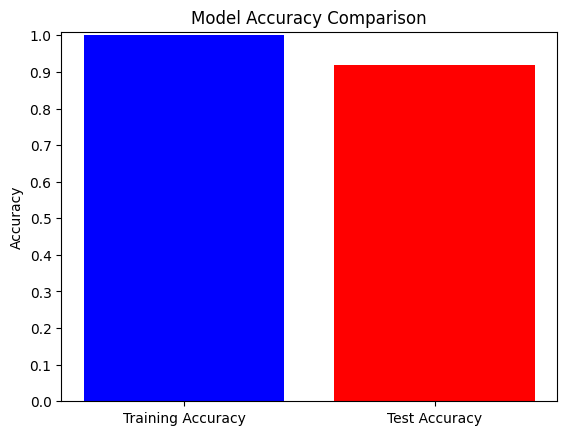

In [48]:
plt.bar(['Training Accuracy', 'Test Accuracy'], [training_accuracy, testing_accuracy], color=['blue', 'red'])
plt.ylim(0, 1.01)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()